## Time of Emergence Plots

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os

import cftime
import dask
dask.config.set({'jobqueue.pbs.local-directory': '/glade/scratch/eschlerm'})
import numba
import numpy as np
import pandas as pd
import xarray as xr
#from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from tqdm.auto import tqdm
from distributed import wait

%matplotlib inline

In [2]:
print('xarray '+xr.__version__) ## was working with 17.0
print('dask '+dask.__version__) ## was working with 2021.02.0

xarray 0.17.0
dask 2021.06.2


### Fetch cluster

In [3]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='2:00:00', # Amount of wall time
        interface='ib0', # Interface to use
        job_extra=["-V"]
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [4]:
cluster, client = get_ClusterClient(nmem='20GB') #memory per worker; 4GB was working before
cluster.scale(20) #number of workers; 100 when reading in all ensemble members, previously 150
cluster
#print(cluster.job_script())
#client.restart()
#cluster.close()

### Some helpful functions to open datasets:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to
 - would be nice to replace with dictionary from intakeESM, if available.

In [5]:
def get_members(model):
    members = []
    if model =='CESM1':
        members = [str(i).zfill(3) for i in [*(1+np.arange(35)),*(101+np.arange(7))]]
    else:
        for i,j in zip(1001+20*np.arange(10),1+np.arange(10)):
            s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
            members.append(s)
        for i in [1231,1251,1281,1301]:
            for j in 1+np.arange(10):
                s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
                members.append(s)
    return members

In [6]:
## Updated for new directory structure of LENS2
def file_dict(model,mem,field,hist=True,freq='monthly',component='lnd'):
    ''' returns a dictionary of filepaths keyed by year, for a given ensemble member '''
    mm = get_members(model)[mem]

    filepaths = {}
    
    if model=='CESM1':
        #detailing the directory structure
        topdir = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+ \
                  component+'/proc/tseries/'
        if freq =='monthly': 
            freq = 'monthly/'
            tape = '.h0.'
        else:
            raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
        thisdir = topdir+freq+field+'/'
        if hist: runtype = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        else:    runtype = 'b.e11.BRCP85C5CNBDRD.f09_g16.'
        #find all the relevant files
        files = glob.glob(thisdir+runtype+'*'+tape+field+'*')
    else:
        #detailing the directory structure
        topdir  = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/'+ \
                   component+'/proc/tseries/'
        if freq=='monthly':
            freq    = 'month_1/'
            tape    = '.h0.'
        elif freq=='daily':
            freq    = 'day_1/'
            if component == 'lnd': tape    = '.h5.'
            if component == 'atm': tape    = '.h1.'
        else:
            raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
        thisdir = topdir+freq+field+'/'

        if hist: runtype = 'b.e21.BHISTcmip6.f09_g17.'
        else:    runtype = 'b.e21.BSSP370cmip6.f09_g17.'

        #find all the relevant files
        files = glob.glob(thisdir+runtype+mm+'*'+tape+field+'*')

    for file in files:
        #isolate y1 and y2 from the file name
        ystr = file.split(field)[-1]
        y1 = int(ystr[1:5])
        ystr = ystr.split('-')[1]
        y2 = int(ystr[0:4])
        for yy in np.arange(y1,y2+1):
            filepaths[yy]=file
        
    return filepaths


In [7]:
def get_file(model,mem,field,year,freq='monthly',component='lnd'):
    ''' get a single file for the given model-mem-field-year'''
    hist = True
    if model=='CESM1' and year>2005: hist=False
    if model=='CESM2' and year>2014: hist=False

    filepaths = file_dict(model,mem,field,hist,freq,component)
    if year in filepaths.keys():
        file = filepaths[year]
    else:
        print('file not found for that member')
        file = []
    
    return file

In [8]:
def all_files(model,ens,field,firstyear,lastyear,
              freq='monthly',component='lnd'):
    ''' retrieve a list of files containing the given ensemble'''
    ens = np.array(ens)
    yrs = np.arange(firstyear,lastyear+1)
    files = []    # a list of lists, dim0=ens, dim1=time
    ix = np.zeros(ens.shape)+1
    
    for ee,i in zip(ens,range(len(ens))):
        ffs = []  # a list of files for this ee
        file0 = ''
        first = True
        for yr in yrs:
            #fetch filepaths
            if first:
                hist = True
                if model=='CESM1' and yr>2005: hist=False
                if model=='CESM2' and yr>2014: hist=False
                filepaths = file_dict(model,ee,field,hist,freq,component)
                first     = False  
            #append file if it is new
            if yr in filepaths.keys():
                file = filepaths[yr]
                if file != file0:
                    ffs.append(file)
                    file0 = file

            #trigger new filepaths fetch when needed
            if model=='CESM1' and yr==2005: first=True
            if model=='CESM2' and yr==2014: first=True

        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,ens[ix==1]

In [9]:
def get_data(model,ens,fields,firstyear,lastyear,freq,preprocess,
             component='lnd',chunks={'time':1000}, 
            ):#Preprocess=False,plat=None,plon=None):
    ''' returns an xarray dataset containing the requested ensemble
    model = \'CESM1\' or \'CESM2\'
    ens   = list of members, via simple sequential key 
            e.g. range(50) gets the first 50 members
            [0,2,4] would get the first, third, 
            and fifth ensemble members (see get_members)
    fields = list of desired fields, you do not need to ask for lat/lon/time
    firstyear = int [1850-2100]
    lastyear  = int [1850-2100]
    freq = \'monthly\' or \'daily\' '''

    ds = xr.Dataset()    #instantiate Dataset
    
    #allow for single field or list of fields
    if type(fields)==str: fields=[fields]  
    
    #add fields one at a time to the dataset
    for field in fields:
        files,ens = all_files(model,ens,field,firstyear,lastyear,
                              freq,component)
        ensdim  = xr.DataArray(ens, dims='ens', name='ens')
        dims    = [ensdim,'time']
        # check if all members have the same number of files (not guaranteed)
        nfs = np.array([len(ffs) for ffs in files])
        if np.sum(nfs==nfs[0])==len(nfs):
            one_go=True   # same number of files
        else:
            one_go=False

        if one_go: #read all data in one go
            tmp = xr.open_mfdataset(files,preprocess=preprocess,
                                    combine='nested',parallel=True,
                                    concat_dim=dims,chunks=chunks,
                                    )
        else:      #read data one member at a time and then concat
            dsets = []
            for ffs in files:
                d0 = xr.open_mfdataset(ffs,preprocess=preprocess,
                                       combine='nested',parallel=True,
                                       concat_dim=['time'],chunks=chunks,
                                       )
                dsets.append(d0)
            tmp = xr.concat(dsets,dim=ensdim)
        ds[field] = tmp[field]

    #grab one copy of the various extra variables, e.g. landfrac,area
    tmp = xr.open_dataset(files[0][0])
    for thisvar in tmp.data_vars:
        if 'time' not in tmp[thisvar].coords:
            ds[thisvar]=tmp[thisvar]

    # quick fix to adjust time vector for monthly data        
    if freq=='monthly':
        nmonths = len(ds.time)
        yr0 = ds['time.year'][0].values
        ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

    return ds.sel(time=slice(str(firstyear),str(lastyear)))

In [10]:
def get_landarea(model):
    file= get_file(model,0,'GPP',1990)
    ds = xr.open_dataset(file)
    la = ds['area']*ds['landfrac']
    return la

In [11]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

--------------------
## Start editing here:
- Actually read in data, here monthly data for the whole ensemble

In [12]:
model = 'CESM2'
# starting with ensemble 11 because of error with soils data zsoi in #10
ens = 11+np.arange(3) #determine number of ensemble numbers
nens = len(ens)
firstyear = 1850 #start reading in data this year, range is 1850-2100
lastyear  = 2100 #finish data this year
plat,plon = 68.66 , (360.-149.37) # °N, °W long, lat of Toolik Lake
component ='atm' 
fields    = ['TREFHT','PRECT'] #reference temperature (T at 2m), and precipitation
freq      = 'monthly'

def preprocess(ds, plat=plat,plon=plon):
    '''subset point of interest, not working?'''
    #ds = ds.sel(lat = plat, lon=plon,method='nearest')
    return ds

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsMonth = get_data(model,ens,fields,firstyear,lastyear,freq,preprocess,component)
#Makes workers work
    
dsMonth = dsMonth[fields]
_ = wait(dsMonth) #wait fn prevents workers from being overloaded with memory
dsMonth['REFT'] = dsMonth.TREFHT-273.15
dsMonth['REFT'].attrs = dsMonth.TREFHT.attrs
dsMonth['REFT'].attrs['units'] = 'C'


For monthly average highs and lows can't use monthly TREFHTMX, which are max over the time period
- here calculate monthly high and low temperatures from daily data
- we also have to avoid duplicate values for Jan 2015 that have to be avoided...
- this whole process is kind of memory intensive, could just rean in monthly tmax from CLM?

In [13]:
# add in land monthly variables and combine
freq      = 'monthly'
component='lnd'
fields = ['SOILWATER_10CM','ALT','H2OSNO','NPP','TSOI_10CM']

def preprocess(ds, plat=plat,plon=plon):
    '''subset point of interest, not working?'''
    #ds = ds.sel(lat = plat, lon=plon,method='nearest')
    return ds

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsMonth2 = get_data(model,ens,fields,firstyear,lastyear,freq,preprocess,component)

dsMonth2 = dsMonth2[fields]
dsMonth2 = dsMonth2.persist()
_ = wait(dsMonth2)
# not working to add soil water onto monthly dataset, coords must not be identical?   
#dsMonth['SOILWATER_10CM'] = dsMonth2.SOILWATER_10CM
#dsMonth2['SOILWATER_10CM'].isel(time=0, ens=0).plot() ;
# dsM= xr.merge([dsMonth, dsMonth2])

#Code to convert TSOI data from kelvin to celsius
dsMonth2['TSOI'] = dsMonth2.TSOI_10CM-273.15
dsMonth2['TSOI'].attrs = dsMonth2.TSOI_10CM.attrs
dsMonth2['TSOI'].attrs['units'] = '$^{\circ}$C'
dsMonth2['TSOI_10CM'] = dsMonth2.TSOI

#Code to convert SOILWATER_10CM to %volume
rho_H2O = 1000 #kg/m^3
volume_10CM = .1 #m^3
dsMonth2['SOILWATER'] = dsMonth2.SOILWATER_10CM*100/(rho_H2O*volume_10CM)
dsMonth2['SOILWATER'].attrs = dsMonth2.SOILWATER_10CM.attrs
dsMonth2['SOILWATER'].attrs['units'] = '%Volume'
dsMonth2['SOILWATER_10CM'] = dsMonth2.SOILWATER

print(" -- data read in, start plotting -- ")

 -- data read in, start plotting -- 


In [14]:
dsMonth2

,Array,Chunk
Bytes,1.86 GiB,25.31 MiB
Shape,"(3, 3012, 192, 288)","(1, 120, 192, 288)"
Count,234 Tasks,78 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,1.86 GiB,25.31 MiB
Shape,"(3, 3012, 192, 288)","(1, 120, 192, 288)"
Count,78 Tasks,78 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


## Define Points
Slightly north of Toolik Lake

In [15]:
site = 'Grid cell north of Toolik Lake'
plat,plon = 69 , (360.-149.37) # °N, °W

Toolik Lake

In [16]:
TLsite = 'Toolik Lake'
TLlat,TLlon = 68.63, (360.-149.60) #ºN, ºW

## MASK CREATION
This creates a new data array called dsMonth2, isolating areas of permafrost from permafrost extent in 1850.  Also gets rid of antarctica and himalayas


In [20]:
maxALTmask = dsMonth2.ALT.groupby('time.year').max('time').isel(year=0).max('ens')  #defines largest area of permafrost in 1850 as domain of latxlon we're looking at
dsMonth2 = dsMonth2.where(maxALTmask<40).where(dsMonth2.lat>40).drop('year') #mask non permafrost data

Mask to isolate liquid water in soil --> soiltemp > 0

In [17]:
dsMonth2_liq = dsMonth2.where(dsMonth2['TSOI_10CM']>0)

# #Testing mask
# dsMonth2.TSOI_10CM.mean('ens').sel(lat=plat,lon=plon,method='nearest').isel(time=slice(-108,None)).plot()
# dsMonth2.SOILWATER_10CM.isel(ens=0).sel(lat=plat,lon=plon,method='nearest').isel(time=slice(-108,None)).plot(color='k')
# dsMonth2_liq.SOILWATER_10CM.isel(ens=0).sel(lat=plat,lon=plon,method='nearest').isel(time=slice(-108,None)).plot()


Tests the mask... Should get only arctic permafrost

### Time of emergence for ALT increase

Following Will's script https://github.com/wwieder/CESM2-LE_SnowWater/blob/main/notebooks/StatChangePreprocess.ipynb

Cells 33-35

In [26]:
ann_ALT = dsMonth2.ALT.resample(time='AS').max('time').persist()
ann_ALT['time'] = ann_ALT.time['time.year'].values
# ann_ALT

# ensemble mean and std over first 30 years
dsBase    = ann_ALT.isel(time=slice(0,30)).mean(dim=['time','ens']).compute()
dsBaseStd = ann_ALT.isel(time=slice(0,30)).std(dim=['time','ens']).compute()
# dsBase

#roll_ensMean = ds_ensMean.chunk({"time": 201}).rolling(time=11, center=True).mean(dim='time')
ds_roll = ann_ALT.chunk({"time": 251}).rolling(time=11, center=True).mean().compute()
# Then take mean and std over rolling mean
roll_ensMean = ds_roll.mean('ens').compute()
roll_ensStd  = ds_roll.std('ens').compute()
# ds_roll

ds_ensMean = ann_ALT.mean('ens',skipna=True).compute()
_ = wait(ds_ensMean)

ds_ensStd = ann_ALT.std('ens',skipna=True).compute()
_ = wait(ds_ensStd)

In [23]:
ann_ALT

,Array,Chunk
Bytes,158.84 MiB,216.00 kiB
Shape,"(3, 251, 192, 288)","(1, 1, 192, 288)"
Count,753 Tasks,753 Chunks
Type,float32,numpy.ndarray


In [ ]:
plt.figure(figsize=[12,8])
x = ds_ensMean.time
y = ds_ensMean.sel(lat = plat, lon = plon, method='nearest')
y2 = ds_ensStd.sel(lat = plat, lon = plon, method='nearest')
        
plt.plot(x, y, '-')
plt.fill_between(x, (y - y2), (y + y2), alpha=0.5)
plt.ylabel(dsMonth2.ALT.attrs['long_name']+' ('+dsMonth2.ALT.units+')') ;

x = roll_ensMean.time
y = roll_ensMean.sel(lat = plat, lon = plon, method='nearest')
y2= roll_ensStd.sel(lat = plat, lon = plon, method='nearest')

plt.plot(x, y)
plt.fill_between(x, y - 2*y2, y + 2*y2, alpha=0.5)

dsBase_pt = dsBase.sel(lat = plat, lon = plon, method='nearest')
dsBaseStd_pt = dsBaseStd.sel(lat = plat, lon = plon, method='nearest')

plt.hlines(dsBase_pt, 1850, 2100, colors='k',lw=4) ;
# plt.hlines((dsBase_pt + dsBaseStd_pt), 1850, 2100, colors='k',linestyles='dashed') ;
# plt.hlines((dsBase_pt - dsBaseStd_pt), 1850, 2100, colors='k',linestyles='dashed') 
plt.title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                           loc='left', fontsize='large', fontweight='bold') ;

# find last day when roll mean - 2 std < baseline
test = y - 2*y2
test = xr.DataArray(test)
test = test.where(test<dsBase.sel(lat = plat, lon = plon, method='nearest')).dropna('time')
ToE = test.time.isel(time=-1) #time of emergence
plt.vlines(ToE, test.min()*0.95,test.max()*1.5,colors='r',lw=2,linestyles='dashed') ;
plt.text(ToE+5, test.min()*0.95, ToE.values,color='r') ;
plt.ylim(0,3)

In [ ]:

plt.figure(figsize=[12,8])
x = ds_ensMean.time
y = ds_ensMean.sel(lat = TLlat, lon = TLlon, method='nearest')
y2 = ds_ensStd.sel(lat = TLlat, lon = TLlon, method='nearest')
        
plt.plot(x, y, '-')
plt.fill_between(x, (y - y2), (y + y2), alpha=0.5)
plt.ylabel(dsMonth2.ALT.attrs['long_name']+' ('+dsMonth2.ALT.units+')') ;

x = roll_ensMean.time
y = roll_ensMean.sel(lat = TLlat, lon = TLlon, method='nearest')
y2= roll_ensStd.sel(lat = TLlat, lon = TLlon, method='nearest')

plt.plot(x, y)
plt.fill_between(x, y - 2*y2, y + 2*y2, alpha=0.5)

dsBase_pt = dsBase.sel(lat = TLlat, lon = TLlon, method='nearest')
dsBaseStd_pt = dsBaseStd.sel(lat = TLlat, lon = TLlon, method='nearest')

plt.hlines(dsBase_pt, 1850, 2100, colors='k',lw=4) ;
plt.title(TLsite+': lat = '+str(TLlat)+' lon = '+str(TLlon), 
                           loc='left', fontsize='large', fontweight='bold') ;

# find last day when roll mean - 2 std < baseline
test = y - 2*y2
test = xr.DataArray(test)
test = test.where(test<dsBase.sel(lat = TLlat, lon = TLlon, method='nearest')).dropna('time')
ToE = test.time.isel(time=-1) #time of emergence
plt.vlines(ToE, test.min()*0.95,test.max()*1.5,colors='r',lw=2,linestyles='dashed') ;
plt.text(ToE+5, test.min()*0.95, ToE.values,color='r') ;
# plt.ylim(0,3)

## Time of Emergence for Soil Moisture

In [32]:
ann_SH2O = dsMonth2.SOILWATER_10CM.resample(time='AS').mean('time').persist()
ann_SH2O['time'] = ann_SH2O.time['time.year'].values
ann_SH2O

# ensemble mean and std over first 30 years
dsBase    = ann_SH2O.isel(time=slice(0,30)).mean(dim=['time','ens']).compute()
dsBaseStd = ann_SH2O.isel(time=slice(0,30)).std(dim=['time','ens']).compute()
# dsBase

#roll_ensMean = ds_ensMean.chunk({"time": 201}).rolling(time=11, center=True).mean(dim='time')
ds_roll = ann_SH2O.chunk({"time": 251}).rolling(time=11, center=True).mean().compute()
# Then take mean and std over rolling mean
roll_ensMean = ds_roll.mean('ens').compute()
roll_ensStd  = ds_roll.std('ens').compute()
# ds_roll

ds_ensMean = ann_SH2O.mean('ens',skipna=True).compute()
_ = wait(ds_ensMean)

ds_ensStd = ann_SH2O.std('ens',skipna=True).compute()
_ = wait(ds_ensStd)

In [ ]:
plt.figure(figsize=[12,8])
x = ds_ensMean.time
y = ds_ensMean.sel(lat = plat, lon = plon, method='nearest')
y2 = ds_ensStd.sel(lat = plat, lon = plon, method='nearest')
        
plt.plot(x, y, '-')
plt.fill_between(x, (y - y2), (y + y2), alpha=0.5)
plt.ylabel('Yearly average '+dsMonth2.SOILWATER_10CM.attrs['long_name']+' ('+dsMonth2.SOILWATER_10CM.units+')') ;

x = roll_ensMean.time
y = roll_ensMean.sel(lat = plat, lon = plon, method='nearest')
y2= roll_ensStd.sel(lat = plat, lon = plon, method='nearest')

plt.plot(x, y)
plt.fill_between(x, y - 2*y2, y + 2*y2, alpha=0.5)

dsBase_pt = dsBase.sel(lat = plat, lon = plon, method='nearest')
dsBaseStd_pt = dsBaseStd.sel(lat = plat, lon = plon, method='nearest')

plt.hlines(dsBase_pt, 1850, 2100, colors='k',lw=4) ;
plt.title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                           loc='left', fontsize='large', fontweight='bold') ;

# # find last day when roll mean - 2 std < baseline
test = y + 2*y2
test = xr.DataArray(test)
test = test.where(test>dsBase.sel(lat = plat, lon = plon, method='nearest')).dropna('time')
ToE = test.time.isel(time=-1) #time of emergence
plt.vlines(ToE, test.min()*0.95,test.max(),colors='r',lw=2,linestyles='dashed') ;
plt.text(ToE+5, test.min()*0.95, ToE.values,color='r') ;
# plt.ylim(70,80)

## Time of Emergence for Liquid Soil Water

In [ ]:
ann_SH2O = dsMonth2_liq.SOILWATER_10CM.resample(time='AS').mean('time').persist()
ann_SH2O['time'] = ann_SH2O.time['time.year'].values
ann_SH2O

# ensemble mean and std over first 30 years
dsBase    = ann_SH2O.isel(time=slice(0,30)).mean(dim=['time','ens']).compute()
dsBaseStd = ann_SH2O.isel(time=slice(0,30)).std(dim=['time','ens']).compute()
# dsBase

#roll_ensMean = ds_ensMean.chunk({"time": 201}).rolling(time=11, center=True).mean(dim='time')
ds_roll = ann_SH2O.chunk({"time": 251}).rolling(time=11, center=True).mean().compute()
# Then take mean and std over rolling mean
roll_ensMean = ds_roll.mean('ens').compute()
roll_ensStd  = ds_roll.std('ens').compute()
# ds_roll

ds_ensMean = ann_SH2O.mean('ens',skipna=True).compute()
_ = wait(ds_ensMean)

ds_ensStd = ann_SH2O.std('ens',skipna=True).compute()
_ = wait(ds_ensStd)

In [ ]:
plt.figure(figsize=[12,8])
x = ds_ensMean.time
y = ds_ensMean.sel(lat = plat, lon = plon, method='nearest')
y2 = ds_ensStd.sel(lat = plat, lon = plon, method='nearest')
        
plt.plot(x, y, '-')
plt.fill_between(x, (y - y2), (y + y2), alpha=0.5)
plt.ylabel('Yearly Average Soil Liquid Water in top 10cm'+' ('+dsMonth2.SOILWATER_10CM.units+')') ;

x = roll_ensMean.time
y = roll_ensMean.sel(lat = plat, lon = plon, method='nearest')
y2= roll_ensStd.sel(lat = plat, lon = plon, method='nearest')

plt.plot(x, y)
plt.fill_between(x, y - 2*y2, y + 2*y2, alpha=0.5)

dsBase_pt = dsBase.sel(lat = plat, lon = plon, method='nearest')
dsBaseStd_pt = dsBaseStd.sel(lat = plat, lon = plon, method='nearest')

plt.hlines(dsBase_pt, 1850, 2100, colors='k',lw=4) ;
plt.title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                           loc='left', fontsize='large', fontweight='bold') ;

# # find last day when roll mean - 2 std < baseline
test = y + 2*y2
test = xr.DataArray(test)
test = test.where(test>dsBase.sel(lat = plat, lon = plon, method='nearest')).dropna('time')
ToE = test.time.isel(time=-1) #time of emergence
plt.vlines(ToE, test.min()*0.95,test.max(),colors='r',lw=2,linestyles='dashed') ;
plt.text(ToE+5, test.min()*0.95, ToE.values,color='r') ;
# plt.ylim(70,80)

## Time of Emergence for Soil Temperature

In [33]:
ann_temp = dsMonth2.TSOI_10CM.resample(time='AS').mean('time').persist()
ann_temp['time'] = ann_temp.time['time.year'].values

# ensemble mean and std over first 30 years
dsBase    = ann_temp.isel(time=slice(0,30)).mean(dim=['time','ens']).compute()
dsBaseStd = ann_temp.isel(time=slice(0,30)).std(dim=['time','ens']).compute()
# dsBase

#roll_ensMean = ds_ensMean.chunk({"time": 201}).rolling(time=11, center=True).mean(dim='time')
ds_roll = ann_temp.chunk({"time": 251}).rolling(time=11, center=True).mean().compute()
# Then take mean and std over rolling mean
roll_ensMean = ds_roll.mean('ens').compute()
roll_ensStd  = ds_roll.std('ens').compute()
# ds_roll

ds_ensMean = ann_temp.mean('ens',skipna=True).compute()
_ = wait(ds_ensMean)

ds_ensStd = ann_temp.std('ens',skipna=True).compute()
_ = wait(ds_ensStd)

In [ ]:
plt.figure(figsize=[12,8])
x = ds_ensMean.time
y = ds_ensMean.sel(lat = plat, lon = plon, method='nearest')
y2 = ds_ensStd.sel(lat = plat, lon = plon, method='nearest')
        
plt.plot(x, y, '-')
plt.fill_between(x, (y - y2), (y + y2), alpha=0.5)
plt.ylabel(dsMonth2.TSOI_10CM.attrs['long_name']+' ('+dsMonth2.TSOI_10CM.units+')') ;

x = roll_ensMean.time
y = roll_ensMean.sel(lat = plat, lon = plon, method='nearest')
y2= roll_ensStd.sel(lat = plat, lon = plon, method='nearest')

plt.plot(x, y)
plt.fill_between(x, y - 2*y2, y + 2*y2, alpha=0.5)

dsBase_pt = dsBase.sel(lat = plat, lon = plon, method='nearest')
dsBaseStd_pt = dsBaseStd.sel(lat = plat, lon = plon, method='nearest')

plt.hlines(dsBase_pt, 1850, 2100, colors='k',lw=4) ;
plt.title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                           loc='left', fontsize='large', fontweight='bold') ;

# find last day when roll mean - 2 std < baseline
test = y - 2*y2
test = xr.DataArray(test)
test = test.where(test<dsBase.sel(lat = plat, lon = plon, method='nearest')).dropna('time')
ToE = test.time.isel(time=-1) #time of emergence
plt.vlines(ToE, test.min()*0.95,test.max()*1.5,colors='r',lw=2,linestyles='dashed') ;
plt.text(ToE+5, test.min()*0.95, ToE.values,color='r') ;
# plt.ylim(0,3)

## Time of Emergence NPP

In [34]:
ann_NPP = dsMonth2.NPP.resample(time='AS').mean('time').persist()
ann_NPP['time'] = ann_NPP.time['time.year'].values

# ensemble mean and std over first 30 years
dsBase    = ann_NPP.isel(time=slice(0,30)).mean(dim=['time','ens']).compute()
dsBaseStd = ann_NPP.isel(time=slice(0,30)).std(dim=['time','ens']).compute()
# dsBase

#roll_ensMean = ds_ensMean.chunk({"time": 201}).rolling(time=11, center=True).mean(dim='time')
ds_roll = ann_NPP.chunk({"time": 251}).rolling(time=11, center=True).mean().compute()
# Then take mean and std over rolling mean
roll_ensMean = ds_roll.mean('ens').compute()
roll_ensStd  = ds_roll.std('ens').compute()
# ds_roll

ds_ensMean = ann_NPP.mean('ens',skipna=True).compute()
_ = wait(ds_ensMean)

ds_ensStd = ann_NPP.std('ens',skipna=True).compute()
_ = wait(ds_ensStd)

In [ ]:
plt.figure(figsize=[12,8])
x = ds_ensMean.time
y = ds_ensMean.sel(lat = plat, lon = plon, method='nearest')
y2 = ds_ensStd.sel(lat = plat, lon = plon, method='nearest')
        
plt.plot(x, y, '-')
plt.fill_between(x, (y - y2), (y + y2), alpha=0.5)
plt.ylabel(dsMonth2.NPP.attrs['long_name']+' ('+dsMonth2.NPP.units+')') ;

x = roll_ensMean.time
y = roll_ensMean.sel(lat = plat, lon = plon, method='nearest')
y2= roll_ensStd.sel(lat = plat, lon = plon, method='nearest')

plt.plot(x, y)
plt.fill_between(x, y - 2*y2, y + 2*y2, alpha=0.5)

dsBase_pt = dsBase.sel(lat = plat, lon = plon, method='nearest')
dsBaseStd_pt = dsBaseStd.sel(lat = plat, lon = plon, method='nearest')

plt.hlines(dsBase_pt, 1850, 2100, colors='k',lw=4) ;
plt.title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                           loc='left', fontsize='large', fontweight='bold') ;

# find last day when roll mean - 2 std < baseline
test = y - 2*y2
test = xr.DataArray(test)
test = test.where(test<dsBase.sel(lat = plat, lon = plon, method='nearest')).dropna('time')
ToE = test.time.isel(time=-1) #time of emergence
plt.vlines(ToE, test.min()*0.95,test.max()*1.5,colors='r',lw=2,linestyles='dashed') ;
plt.text(ToE+5, test.min()*0.95, ToE.values,color='r') ;
# plt.ylim(0,3)

## Time of Emergence Area Plots

In [38]:
# ann_ALT = dsMonth2.ALT.resample(time='AS').max('time').persist()
# ann_ALT['time'] = ann_ALT.time['time.year'].values
annual = xr.merge([ann_NPP, ann_temp, ann_SH2O, ann_ALT])
annual = annual.chunk({"time": 251})

In [39]:
%%time

# ann_ALT = dsMonth2.ALT.resample(time='AS').max('time').persist()
# ann_ALT['time'] = ann_ALT.time['time.year'].values


test_vars = ['NPP','TSOI_10CM','SOILWATER_10CM','ALT']
trend = ['pos','pos','neg','pos']

#persist or compute?

dsBase    = annual.isel(time=slice(0,30)).mean(dim=['time','ens']).persist()
_ = wait(dsBase)
dsBaseStd = annual.isel(time=slice(0,30)).std(dim=['time','ens']).persist()
_ = wait(dsBaseStd)

ds_roll = annual.rolling(time=10, center=True).mean().persist()
_ = wait(ds_roll)

CPU times: user 2.76 s, sys: 320 ms, total: 3.08 s
Wall time: 3.62 s


In [40]:
# Then take mean and std over rolling mean
roll_ensMean = ds_roll.mean('ens').persist()
_ = wait(roll_ensMean)
roll_ensStd  = ds_roll.std('ens').persist()
_ = wait(roll_ensStd)

In [41]:
test = roll_ensMean.ALT - 2*roll_ensStd.ALT
test = test.where(test<dsBase.ALT)
# GOI = (test.sel(lat = plat, lon = plon, method='nearest')).dropna('time')

In [42]:
ToE = xr.Dataset({'lat': (['lat'], dsMonth2.lat), 'lon': (['lon'], dsMonth2.lon)})
ToE

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    *empty*

In [43]:
for v in range(len(test_vars)):
    if trend[v] == 'pos':  # variables w/ positive trend:
        temp = roll_ensMean[test_vars[v]] - 2*roll_ensStd[test_vars[v]]
        temp = temp.time.where(temp<dsBase[test_vars[v]])
    else:
        temp = roll_ensMean[test_vars[v]] + 2*roll_ensStd[test_vars[v]]
        temp = temp.time.where(temp>dsBase[test_vars[v]])
        
        #check to see if it works
#     if v == 3:
#         #print(temp.max(dim='time'))
#         temp.max(dim='time').plot(robust=True)
    ToE[test_vars[v]] = temp.max(dim='time')

#     ToE = ToE.where(ToE>1850)
#     ToE = ToE.where(ToE<2095)

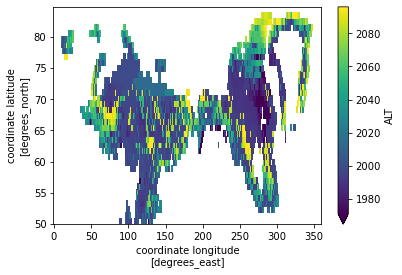

In [48]:
ToE.ALT.sel(lat=slice(50,85)).plot(robust=True)